## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [6]:
import random
import numpy as np
from matplotlib import pyplot as plt

# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms

from avalanche.training import Naive, Replay, plugins

# from avalanche.models import SimpleMLP, SimpleCNN
from avalanche.benchmarks.classic import (
    RotatedMNIST,
    PermutedMNIST,
    PermutedOmniglot,
    RotatedOmniglot,
)

# Local imports
import utils
from models import SimpleCNN, SimpleMLP
from strategies import LatentReplay, GenerativeLatentReplay


In [7]:
# Config
device = utils.get_device()

# Dataset specific atgtributes
dataset = RotatedMNIST  # PermutedMNIST
n_classes = 10
input_size = 784
n_experiences = 3

# Model specification
model = "mlp"
hidden_size = 64
n_hidden_layers = 4

# Frozen backbone
freeze_depth = 2
assert freeze_depth <= n_hidden_layers
if model == 'mlp':
    latent_layer_number = freeze_depth * 3
elif model == 'cnn':
    latent_layer_number = freeze_depth * 2

# Hyperparams
lr = 0.001
l2 = 0.0005
momentum = 0.9

n_epochs = 20
train_mb_size = 128
eval_mb_size = 1024
eval_every = 1
cl_plugins = None #[plugins.EarlyStoppingPlugin(patience=1, val_stream_name="train_stream")]  # JA: need to set params

replay_buffer_size = 5000

# Reproducibility
SEED = 109
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
# Model
networks = [None, None, None, None]
n = len(networks)

if model == "mlp":
    for i in range(n):
        networks[i] = SimpleMLP(
            hidden_layers=n_hidden_layers,
            num_classes=n_classes,
            hidden_size=hidden_size,
        )
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
    )

elif model == "cnn":
    for i in range(n):
        networks[i] = SimpleCNN(num_classes=n_classes)
    transform = transforms.Compose([transforms.ToTensor()])

else:
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose(
        [
            # transforms.Lambda(lambda x: x.convert('RGB')),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ]
    )

# Continual learning strategy
lat_replay_strategy = LatentReplay(
    model=networks[0],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    device=device,
    subsample_replays=True,
    eval_every=eval_every,
    plugins=cl_plugins,
)

non_lat_replay_strategy = LatentReplay(
    model=networks[1],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=0,
    device=device,
    subsample_replays=True,
    eval_every=eval_every,
    plugins=cl_plugins,
)

replay_strategy = Replay(
    model=networks[2],
    optimizer=SGD(networks[2].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
    criterion=CrossEntropyLoss(),
    eval_every=eval_every,
    plugins=cl_plugins,
)


naive_strategy = Naive(
    model=networks[3],
    optimizer=SGD(networks[3].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
    eval_every=eval_every,
)


FrozenNet(
  (lat_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (end_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)
FrozenNet(
  (lat_features): Sequential()
  (end_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): LazyLinear(in_features=0, out_features=64, bias=True)
    (7): ReLU

In [9]:
for model, results in [
    (lat_replay_strategy, (results_lat_replay := [])),
    #(naive_strategy, (results_naive := [])),
    #(replay_strategy, (results_replay := [])),
    #(non_lat_replay_strategy, (results_non_lat_replay := [])),
]:
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        rotations_list=[0,60,300]
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(train_stream))


-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 59/59 [00:09<00:00,  6.09it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 2.3061
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.1059
-- >> End of eval phase << --
	Loss_Stream/eval_phase/train_stream/Task000 = 2.3061
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.1059
100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.3033
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1093
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 59/59 [00:10<00:00,  5.80it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 2.2992
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.1152
-- >>

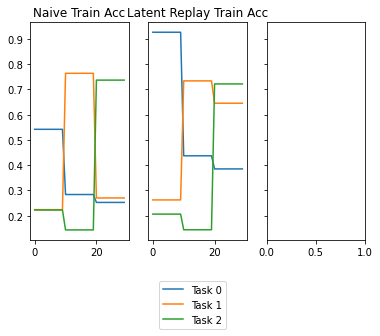

In [11]:
# JA: Next step - replace internal model.
# - model def                               ✅
# - frozen layer name                       ✅
# - batch renorm stuff...?                  ✅ (removed)

# JA: 2nd step
# - check replays work                      ✅
# - check replays work for subsequent exp's ✅
# - check latent replays work               ✅
# - add replay subsampling method           ✅

# JA: 3rd step
# - make GMM
# - add GMM to model replay storage 

fig, axes = plt.subplots(1, 3, sharey='row')
repeat_vals = 10

try:
    results_naive_clean = utils.plot_results(
        results_naive, "Naive", axes[0], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_lat_replay_clean = utils.plot_results(
        results_lat_replay, "Latent Replay", axes[1], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_lat_replay_2_clean = utils.plot_results(
        results_non_lat_replay, "Non-Latent Replay", axes[2], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass

utils.plot_single_legend(fig)
